In [1]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch

import torchvision
import torchvision.transforms as transforms

from torchvision import transforms
from torchvision.datasets import ImageFolder

from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix

from torcheval.metrics import MulticlassAUROC

from collections import OrderedDict

from torch.autograd import Variable



#mcc implementation
from torchmetrics.classification import MultilabelMatthewsCorrCoef

# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_transforms = transforms.Compose(
    [transforms.Resize((224,224)),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 16
#image_size = (224, 224, 3)

train_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/train', transform=train_transforms)
validation_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/val', transform=transform)
test_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/test', transform=transform)

#train_set = train_ds
train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=8)

#validation_set = validation_ds
validation_loader = T.utils.data.DataLoader(validation_set, batch_size=batch_size,shuffle=True, num_workers=8)

#test_set = test_ds
test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=True, num_workers=8)

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [4]:
class ResBottleBlock(nn.Module):
    
    def __init__(self, in_planes, bottleneck_width=4, stride=1, expansion=1):
        super(ResBottleBlock, self).__init__()
        self.conv0=nn.Conv2d(in_planes,bottleneck_width,1,stride=1,bias=False)
        self.bn0 = nn.BatchNorm2d(bottleneck_width)
        self.conv1=nn.Conv2d(bottleneck_width,bottleneck_width,3,stride=stride,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(bottleneck_width)
        self.conv2=nn.Conv2d(bottleneck_width,expansion*in_planes,1,bias=False)
        self.bn2=nn.BatchNorm2d(expansion*in_planes)
        
        self.shortcut=nn.Sequential()
        if stride!=1 or expansion!=1:
            self.shortcut=nn.Sequential(
                nn.Conv2d(in_planes,in_planes*expansion,1,stride=stride,bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn0(self.conv0(x)))
        out = F.relu(self.bn1(self.conv1(out)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class BasicBlock_A(nn.Module):
    def __init__(self, in_planes, num_paths=32, bottleneck_width=4, expansion=1, stride=1):
        super(BasicBlock_A,self).__init__()
        self.num_paths = num_paths
        for i in range(num_paths):
            setattr(self,'path'+str(i),self._make_path(in_planes,bottleneck_width,stride,expansion))

        # self.paths=self._make_path(in_planes,bottleneck_width,stride,expansion)
        self.conv0=nn.Conv2d(in_planes*expansion,expansion*in_planes,1,stride=1,bias=False)
        self.bn0 = nn.BatchNorm2d(in_planes * expansion)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or expansion != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, in_planes * expansion, 1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = self.path0(x)
        for i in range(1,self.num_paths):
            if hasattr(self,'path'+str(i)):
                out+getattr(self,'path'+str(i))(x)
            # out+=self.paths(x)
            # getattr
        # out = torch.sum(out, dim=1)
        out = self.bn0(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

    def _make_path(self, in_planes, bottleneck_width, stride, expansion):
        layers = []
        layers.append(ResBottleBlock(
            in_planes, bottleneck_width, stride, expansion))
        return nn.Sequential(*layers)




class BasicBlock_C(nn.Module):
    """
    increasing cardinality is a more effective way of 
    gaining accuracy than going deeper or wider
    """

    def __init__(self, in_planes, bottleneck_width=4, cardinality=32, stride=1, expansion=2):
        super(BasicBlock_C, self).__init__()
        inner_width = cardinality * bottleneck_width
        self.expansion = expansion
        self.basic = nn.Sequential(OrderedDict(
            [
                ('conv1_0', nn.Conv2d(in_planes, inner_width, 1, stride=1, bias=False)),
                ('bn1', nn.BatchNorm2d(inner_width)),
                ('act0', nn.ReLU()),
                ('conv3_0', nn.Conv2d(inner_width, inner_width, 3, stride=stride, padding=1, groups=cardinality, bias=False)),
                ('bn2', nn.BatchNorm2d(inner_width)),
                ('act1', nn.ReLU()),
                ('conv1_1', nn.Conv2d(inner_width, inner_width * self.expansion, 1, stride=1, bias=False)),
                ('bn3', nn.BatchNorm2d(inner_width * self.expansion))
            ]
        ))
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != inner_width * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, inner_width * self.expansion, 1, stride=stride, bias=False)
            )
        self.bn0 = nn.BatchNorm2d(self.expansion * inner_width)

    def forward(self, x):
        out = self.basic(x)
        out += self.shortcut(x)
        out = F.relu(self.bn0(out))
        return out

class ResNeXt(nn.Module):
    def __init__(self, num_blocks, cardinality, bottleneck_width, expansion=2, num_classes=291):
        super(ResNeXt, self).__init__()
        self.cardinality = cardinality
        self.bottleneck_width = bottleneck_width
        self.in_planes = 64
        self.expansion = expansion
        
        self.conv0 = nn.Conv2d(3, self.in_planes, kernel_size=3, stride=1, padding=1)
        self.bn0 = nn.BatchNorm2d(self.in_planes)
        self.pool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1=self._make_layer(num_blocks[0],1)
        self.layer2=self._make_layer(num_blocks[1],2)
        self.layer3=self._make_layer(num_blocks[2],2)
        self.layer4=self._make_layer(num_blocks[3],2)
        self.linear = nn.Linear(12544, num_classes)

    def forward(self, x):
        out = F.relu(self.bn0(self.conv0(x)))
        # out = self.pool0(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    def _make_layer(self, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock_C(self.in_planes, self.bottleneck_width, self.cardinality, stride, self.expansion))
            self.in_planes = self.expansion * self.bottleneck_width * self.cardinality
        self.bottleneck_width *= 2
        return nn.Sequential(*layers)

def resnext26_1x64d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=4, bottleneck_width=4)
    
def resnext26_2x64d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=2, bottleneck_width=64)


def resnext26_4x32d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=4, bottleneck_width=32)


def resnext26_8x16d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=8, bottleneck_width=16)


def resnext26_16x8d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=16, bottleneck_width=8)


def resnext26_32x4d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=32, bottleneck_width=4)


def resnext26_64x2d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=32, bottleneck_width=4)


def resnext50_2x64d():
    return ResNeXt(num_blocks=[3, 4, 6, 3], cardinality=2, bottleneck_width=64)


def resnext50_32x4d():
    return ResNeXt(num_blocks=[3, 4, 6, 3], cardinality=32, bottleneck_width=4)


In [5]:
net = resnext26_1x64d().to(device)
net.to(device)

ResNeXt(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock_C(
      (basic): Sequential(
        (conv1_0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act0): ReLU()
        (conv3_0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU()
        (conv1_1): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): Conv2d(64, 32, 

In [6]:
criterion = nn.CrossEntropyLoss()

# also the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)

#dynamic learning rate
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [7]:
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

test_acc = []

mcc_list = []

lrs = []
steps = []

epoch_affichage = 1

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

for epoch in tqdm(range(0, 36)):  # loop over the dataset multiple times
    
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)
    
    
    """
    print("predicted = ",predicted)
    print("labels = ",labels)
    """
    
    #MCC implementation
    """
    metric_mcc = MultilabelMatthewsCorrCoef(num_labels=291)
    metric_mcc(predicted, labels)
    mcc_list.append(metric_mcc)
    """
    
    #zone pour mettre le learning rate dynamique
    """
    steps.append(epoch)
    lrs.append(scheduler.get_last_lr()[0])
    scheduler.step()
    """
    
    if epoch % epoch_affichage == 0: #ici changer pour la frequence d'affichage
        print('\nEpoch: {}'.format(epoch))
        print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))
       
    
    
    
    # evaluate on the validation set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the validation set
    with T.no_grad():
        correct = 0
        total = 0
        validation_running_loss = .0
        for data in validation_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if epoch == 35: # a changer si besoin d'afficher la matrice de confusion, a mettre à epoch-1
                # Append batch prediction results
                predlist=torch.cat([predlist,predicted.view(-1).cpu()])
                lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
                

        validation_running_loss /= len(validation_loader)
        validation_loss.append(validation_running_loss)
        validation_running_acc = correct / total
        validation_acc.append(validation_running_acc)
        
        if epoch % epoch_affichage == 0: #ici changer pour la frequence d'affichage
            print('validation Acc.  => {:.3f}%'.format(100 * validation_running_acc), end=' | ')
            print('validation Loss  => {:.5f}'.format(validation_running_loss))

    with torch.no_grad():
        correct_t = 0
        total_t = 0
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_t += labels.size(0)
            correct_t += (predicted == labels).sum().item()
            
            running_acc_t = correct_t / total_t
        test_acc.append(running_acc_t)
    
        if epoch % epoch_affichage == 0: #ici changer pour la frequence d'affichage
            print('Accuracy of the network on test images: %d %%' % (100 * correct_t / total_t))

print('Finished Training')

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch: 0
Train Acc. => 20.280% | Train Loss => 3.64893
validation Acc.  => 36.629% | validation Loss  => 2.50076
Accuracy of the network on test images: 37 %

Epoch: 1
Train Acc. => 47.029% | Train Loss => 2.03523
validation Acc.  => 53.274% | validation Loss  => 1.74576
Accuracy of the network on test images: 53 %

Epoch: 2
Train Acc. => 58.691% | Train Loss => 1.51095
validation Acc.  => 59.403% | validation Loss  => 1.49816
Accuracy of the network on test images: 59 %

Epoch: 3
Train Acc. => 66.057% | Train Loss => 1.21793
validation Acc.  => 64.274% | validation Loss  => 1.29021
Accuracy of the network on test images: 63 %

Epoch: 4
Train Acc. => 70.841% | Train Loss => 1.02625
validation Acc.  => 66.403% | validation Loss  => 1.21033
Accuracy of the network on test images: 66 %

Epoch: 5
Train Acc. => 74.414% | Train Loss => 0.89385
validation Acc.  => 69.742% | validation Loss  => 1.06526
Accuracy of the network on test images: 69 %

Epoch: 6
Train Acc. => 77.092% | Train Loss =

## Visualization

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

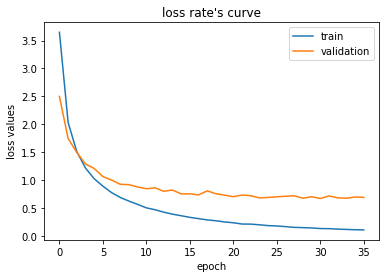

In [9]:
plt.plot(train_loss, label='train')
plt.plot(validation_loss, label='validation')
plt.xlabel("epoch")
plt.ylabel("loss values")
plt.title("loss rate's curve")
plt.legend()
plt.show()

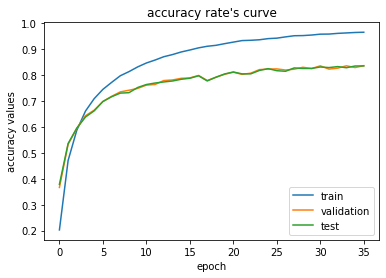

In [10]:
plt.plot(train_acc, label='train')
plt.plot(validation_acc, label='validation')
plt.plot(test_acc, label='test')
plt.xlabel("epoch")
plt.ylabel("accuracy values")
plt.title("accuracy rate's curve")
plt.legend()
plt.show()

In [11]:
#plt.plot(mcc_list, label='MCC')
#plt.xlabel("epoch")
#plt.ylabel("MCC values")
#plt.title("MCC curve")
#plt.legend()
#plt.show()

In [12]:
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)


[[16  2  0 ...  0  0  0]
 [ 0 53  0 ...  0  0  0]
 [ 0  0 17 ...  0  0  0]
 ...
 [ 0  0  0 ... 18  0  0]
 [ 0  0  0 ...  0 21  0]
 [ 0  0  0 ...  0  0 38]]


<AxesSubplot:>

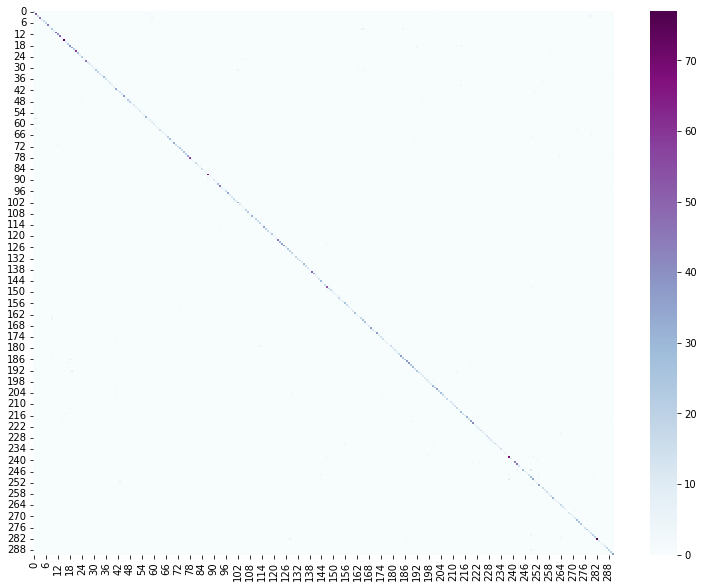

In [13]:
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(conf_mat, annot=False, ax=ax, cmap="BuPu")

In [14]:
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[ 80.          89.83050847  70.83333333  84.21052632  87.5
  89.47368421  81.81818182  97.87234043  80.          65.78947368
  80.         100.          80.85106383  92.85714286  66.66666667
  89.53488372 100.          92.30769231  77.35849057  81.81818182
  84.61538462  86.76470588  83.87096774 100.          91.66666667
  28.57142857  93.61702128 100.          71.42857143 100.
 100.          70.58823529  79.16666667 100.         100.
  77.77777778  86.66666667  58.33333333  75.          44.44444444
  63.63636364  91.66666667  77.77777778  87.5         92.85714286
  95.          83.33333333  82.14285714  86.95652174  75.
 100.          87.5         87.5        100.          80.
  72.72727273  93.93939394  24.          90.90909091  73.33333333
  58.82352941  80.          54.54545455  72.72727273  71.42857143
  55.55555556  83.33333333  61.76470588  84.84848485  83.33333333
  94.28571429  80.          95.          91.66666667  80.95238095
  96.42857143  83.33333333  85.          90.625  

## Save

In [15]:
#torch.save(net.state_dict(), "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/dict_Linh_network_1st_try")

In [16]:
#torch.save(net, "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/Linh_network_entire_model_1st_try")

In [17]:
"""
from torch.utils.data.dataloader import DataLoader


train_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

from torchvision.utils import make_grid

def show_batch(dl):
    #Plot images grid of single batch
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

"""

'\nfrom torch.utils.data.dataloader import DataLoader\n\n\ntrain_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)\n\nfrom torchvision.utils import make_grid\n\ndef show_batch(dl):\n    #Plot images grid of single batch\n    for images, labels in dl:\n        fig,ax = plt.subplots(figsize = (16,12))\n        ax.set_xticks([])\n        ax.set_yticks([])\n        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))\n        break\n        \nshow_batch(train_dl)\n\n'

In [18]:
"""
transform2 = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor()])

train_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/TRAIN/', transform=transform2)

train_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

        
show_batch(train_dl2)
"""

"\ntransform2 = transforms.Compose(\n    [transforms.Resize((224, 224)),\n     transforms.ToTensor()])\n\ntrain_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/TRAIN/', transform=transform2)\n\ntrain_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)\n\n        \nshow_batch(train_dl2)\n"